In [122]:
# import sys
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download ru_core_news_sm
# !{sys.executable} -m pip install gensim
# !{sys.executable} -m pip install pyLDAvis
# !{sys.executable} -m pip install WordCloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: c:\users\user\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip


In [1]:
import json # обработка json файлов
import pandas as pd # работа с pandas DataFrame
import numpy as np # для работы с числами и последовательностями (финальный вывод)
import matplotlib.pyplot as plt # вывод графиков
import re # регулярные выражения для обработки статей
import string # обработка текста
import spacy # обработка текста + лемматизация слов (приведение к нормальной форме) + создание корпуса
import gensim # для объединения слов в n-граммы
import pyLDAvis.gensim_models # визуализация
from gensim.corpora import Dictionary # для создания словаря
from gensim.models import LdaModel, LsiModel, Nmf, CoherenceModel # модель + метрика оценивания

import warnings # выключение отображение warning-ов
warnings.filterwarnings('ignore')

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
article_filename = "articles.json" # путь до файла с полным сохранением статей

In [9]:
articles = []
with open(article_filename, encoding="utf-8") as file:
    for line in file:
        articles.append(json.loads(line))
data = pd.DataFrame(articles)
data.head()

,article_id,title,category,tags,text
0,https://www.nn.ru/text/entertainment/2023/01/1...,Кто такой цуцик и где раки зимуют? Попробуйте ...,entertainment,"Развлечения,Знания,История,Развлечения,Тест,Фр...","Если бы не было фразеологизмов, наша речь (а в..."
1,https://www.nn.ru/text/entertainment/2023/01/1...,Снова как мальчик: Филипп Киркоров резко помол...,entertainment,"Развлечения,Филипп Киркоров,Звезды,Шоу-бизнес","Редко кто может похвастаться тем, что после ка..."
2,https://www.nn.ru/text/entertainment/2023/01/1...,2023 — это колесница: каким будет год Черного ...,entertainment,"Развлечения,Гороскоп,Нумеролог,Прогноз нумерол...","Если присмотреться внимательнее, то можно обна..."
3,https://www.nn.ru/text/entertainment/2023/01/1...,Вам не решить: 10 советских задач в картинках ...,entertainment,"Развлечения,СССР,Интересный тест,Тест,Внимание...",Ставить опыты над возможностями человеческих п...
4,https://www.nn.ru/text/entertainment/2023/01/1...,Не только «Ёлки-9»: что больше всего приглянул...,entertainment,Развлечения,Wink представляет самые популярные фильмы и се...


# 1) Предобработка данных

In [12]:
nlp = spacy.load("ru_core_news_sm") # nlp (Natural Language Processing) - Объект Language с загруженным pipeline-ом (tok2vec, morphologizer, parser, senter, ner, attribute_ruler, lemmatizer)

In [13]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e'])

In [16]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', text) for text in data["text"]] # удаление ссылок
corpus = [text.lower() for text in corpus] # приведение к нижнему регистру
corpus = [re.sub(r'[\d\w-]{1,}\.(ru|com|ua)', ' ', text) for text in corpus] # удаление неполных ссылок
# в статьях нет \n или \t

regex_dig = re.compile('[%s]' % re.escape(string.digits))
corpus = [regex_dig.sub(' ', text) for text in corpus] # убираем цифры

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
corpus = [regex_punct.sub(' ', text) for text in corpus] # убираем пунктуацию

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
corpus = [regex_symb.sub(' ', text) for text in corpus] # убираем дополнительные символы

corpus = [re.sub(' +', ' ', text) for text in corpus] # оставляем максимум 1 пробел
corpus = [text.strip() for text in corpus] # удаляем лишние пробелы в начале и конце статей

In [20]:
docs = []
for text in corpus:
    docs.append(nlp(text)) # передача данных в pipeline Natural Language Processing

сохранение, так как предыдущий блок очень долго выполнялся

In [2]:
import pickle
f = open(r'nlp_articles.pkl', 'wb') # сохранение в бинарном формате (1.5 ГИГАБАЙТА?!)
pickle.dump(docs, f)

NameError: name 'docs' is not defined

In [5]:
docs = []

In [6]:
f = open(r'nlp_articles.pkl', 'rb')
docs = pickle.load(f)
print(docs[0][0].is_stop) # проверка работы

EOFError: Ran out of input

In [23]:
data["text"][0]

'Если бы не было фразеологизмов, наша речь (а возможно, и вся жизнь) была бы куда скучнее. Но еще интереснее не просто пользоваться этими выражениями, но и знать, откуда они произошли и почему мы вообще так стали говорить. Узнать это мы и предлагаем вам прямо сейчас. И не бойтесь ошибиться — это тест не про исключительные знания, а про то, что нас окружает.   '

In [24]:
docs[0]

если бы не было фразеологизмов наша речь а возможно и вся жизнь была бы куда скучнее но еще интереснее не просто пользоваться этими выражениями но и знать откуда они произошли и почему мы вообще так стали говорить узнать это мы и предлагаем вам прямо сейчас и не бойтесь ошибиться это тест не про исключительные знания а про то что нас окружает

In [59]:
# for ind, i in enumerate(docs[0]):
#     print(ind, "\t\t", i, "\t\t", i.pos_, "\t\t", i.is_stop)

0 		 если 		 SCONJ 		 True
1 		 бы 		 AUX 		 True
2 		 не 		 PART 		 True
3 		 было 		 VERB 		 True
4 		 фразеологизмов 		 NOUN 		 False
5 		 наша 		 DET 		 True
6 		 речь 		 NOUN 		 False
7 		 а 		 CCONJ 		 True
8 		 возможно 		 ADV 		 True
9 		 и 		 PART 		 True
10 		 вся 		 DET 		 True
11 		 жизнь 		 NOUN 		 False
12 		 была 		 AUX 		 True
13 		 бы 		 AUX 		 True
14 		 куда 		 ADV 		 True
15 		 скучнее 		 ADJ 		 False
16 		 но 		 CCONJ 		 True
17 		 еще 		 ADV 		 True
18 		 интереснее 		 ADJ 		 False
19 		 не 		 PART 		 True
20 		 просто 		 PART 		 True
21 		 пользоваться 		 VERB 		 False
22 		 этими 		 DET 		 True
23 		 выражениями 		 NOUN 		 False
24 		 но 		 CCONJ 		 True
25 		 и 		 CCONJ 		 True
26 		 знать 		 VERB 		 False
27 		 откуда 		 ADV 		 True
28 		 они 		 PRON 		 True
29 		 произошли 		 VERB 		 False
30 		 и 		 CCONJ 		 True
31 		 почему 		 ADV 		 True
32 		 мы 		 PRON 		 True
33 		 вообще 		 ADV 		 True
34 		 так 		 ADV 		 True
35 		 стали 		 VERB 		 True
36 		 говорит

In [60]:
texts, article, skl_texts = [], [], []
# additional_stop_words = 
# texts - массив лемматизированных статей (массив из массивов лемм для статей)
# article - массив лемм в одной статье (зануляется при окончании рассматриваемой статьи)
# skl_texts - массив текстов из лемм
for text in docs:
    for idx, w in enumerate(text): # проходимся по всем словам из выбранной статьи
        # если это не стоп-слово и не знак препинания (+ число, конец строки), добавляем его в нашу статью!
#         if not w.is_stop and not w.is_punct and not w.like_num and not w.text in additional_stop_words: # w.text - для взятия слова
        if not w.is_stop and not w.is_punct and not w.like_num and not w.text in additional_stop_words and not w.pos_ == "VERB": # w.text - для взятия слова
            # добавляем лематизированную версию слова
            article.append(w.lemma_)
        # если это новая строка, это означает, что мы находимся в нашем следующем документе
        if idx == (len(text) - 1):
            skl_texts.append(' '.join(article))
            texts.append(article)
            article = []

In [61]:
print(texts[0])

['фразеологизм', 'речь', 'скучный', 'интересный', 'выражение', 'прямо', 'тест', 'исключительный', 'знание']


In [62]:
print(skl_texts[0])

фразеологизм речь скучный интересный выражение прямо тест исключительный знание


### Объединение слов в n-граммы

In [63]:
bigram = gensim.models.Phrases(texts) # обучение модели нахождения n-грамм

In [64]:
print(texts[-1], "\n\n", bigram[texts[-1]])

['база', 'архангельский', 'филиал', 'россельхозбанк', 'адрес', 'архангельск', 'ул', 'карл', 'либкнехт', 'центр', 'оказание', 'услуга', 'бизнес', 'цоу', 'государственный', 'муниципальный', 'услуга', 'услуга', 'акционерный', 'общество', 'федеральный', 'корпорация', 'развитие', 'малый', 'средний', 'предпринимательство', 'юридический', 'лицо', 'индивидуальный', 'предприниматель', 'гражданин', 'предпринимательский', 'деятельность', 'представитель', 'малый', 'средний', 'предпринимательство', 'доступный', 'окно', 'приём', 'выдача', 'документ', 'цель', 'организация', 'предоставление', 'государственный', 'муниципальный', 'услуга', 'условие', 'соглашение', 'предприниматель', 'город', 'архангельск', 'документ', 'регистрация', 'юридический', 'лицо', 'консультация', 'налог', 'кредитный', 'продукт', 'банк', 'расчётный', 'счёт', 'депозит', 'комплексный', 'поддержка', 'малый', 'средний', 'предпринимательство', 'клиент', 'насколько', 'важный', 'максимум', 'услуга', 'место', 'появление', 'база', 'банк',

In [149]:
texts_v2 = [bigram[line] for line in texts] # создаём массив лемм для статей с использованием биграммами (во многом он остался схож с обычным texts)

## Вывод самых часто используемых слов в статьях

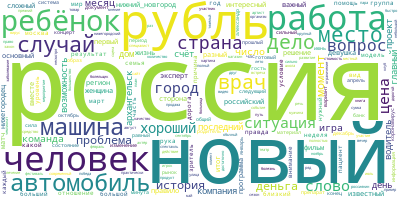

In [120]:
long_string = ','.join(j for sub in texts_v2 for j in sub) # объединяем все слова

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue') # создание WordCloud объекта

wordcloud.generate(long_string)
wordcloud.to_image()

In [150]:
dictionary = Dictionary(texts_v2) # создаём словарь (слова будут в нём не по порядку)

In [69]:
# print(dictionary[2]) # вывод слова по id
# print(dictionary.token2id["интересный"]) # вывод id, под которым слово записано в словаре

интересный
2


In [136]:
corpus = [dictionary.doc2bow(text) for text in texts_v2] # преобразовывание статей в формат bag-of-words (BoW)

In [137]:
corpus[0][0:10] # возвращает: (id слова в словаре, сколько раз оно встречается)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

# 2) Использование моделей

## LSI:

In [133]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary) # создание LSI модели с передачей корупа corpus, определяемое число тем = 10, id2word - ID to word mapping (используем созданный словарь)

In [134]:
lsimodel.show_topics()  # Вывод тем для LSI модели

[(0,
  '0.301*"рубль" + 0.252*"россия" + 0.213*"новый" + 0.176*"автомобиль" + 0.168*"цена" + 0.164*"машина" + 0.158*"ребёнок" + 0.157*"человек" + 0.122*"работа" + 0.111*"страна"'),
 (1,
  '-0.430*"рубль" + -0.285*"автомобиль" + -0.258*"цена" + -0.242*"машина" + 0.197*"игра" + 0.196*"команда" + 0.172*"матч" + 0.170*"ребёнок" + 0.128*"человек" + 0.128*"врач"'),
 (2,
  '-0.293*"матч" + 0.291*"ребёнок" + -0.287*"команда" + -0.286*"игра" + 0.239*"врач" + -0.178*"болельщик" + 0.176*"человек" + -0.161*"нижний_новгород" + -0.134*"россия" + -0.112*"автомобиль"'),
 (3,
  '-0.361*"рубль" + 0.355*"автомобиль" + 0.339*"машина" + 0.171*"новый" + -0.136*"цена" + 0.122*"фильм" + 0.122*"водитель" + -0.120*"врач" + 0.110*"город" + -0.107*"матч"'),
 (4,
  '-0.306*"рубль" + 0.272*"автомобиль" + 0.248*"машина" + 0.243*"врач" + 0.161*"водитель" + 0.151*"случай" + -0.138*"фильм" + 0.133*"пациент" + -0.130*"город" + -0.126*"архангельск"'),
 (5,
  '0.623*"ребёнок" + 0.282*"рубль" + -0.281*"россия" + -0.155*"ст

## LDA:

In [152]:
chunksize = 2000 # Количество документов, которые будут использоваться в каждом блоке обучения
passes = 20 # Количество проходов по корпусу во время обучения
iterations = 40 # Максимальное количество итераций по корпусу при выводе тематического распределения корпуса
eval_every = None  # Don't evaluate model perplexity, takes too much time.

ldamodel = LdaModel(corpus=corpus, # передаваемый поток документов
                    num_topics=10, # Количество запрошенных скрытых тем, которые необходимо извлечь из учебного корпуса.
                    id2word=dictionary, # Mapping id к словам (словарь)
                    chunksize=chunksize, # Количество документов, которые будут использоваться в каждом блоке обучения
                    alpha='auto', # априорное убеждение в распространении тем по документам
                    eta='auto', # априорное убеждение в распределении слов по темам
                    iterations=iterations, # Максимальное количество итераций по корпусу при выводе тематического распределения корпуса
                    passes=passes, # Количество проходов по корпусу во время обучения
                    eval_every=eval_every)

FloatingPointError: underflow encountered in multiply

In [ ]:
ldamodel.show_topics() # Вывод тем для LDA модели

## NMF:

In [141]:
nmfmodel = Nmf(corpus=corpus,
               id2word=dictionary,
               num_topics=10,
               chunksize=chunksize,
               kappa=0.1,
               passes=passes,
               eval_every=eval_every)

In [142]:
nmfmodel.show_topics() # Вывод тем для NMF модели

[(0,
  '0.016*"водитель" + 0.013*"случай" + 0.010*"автомобиль" + 0.009*"машина" + 0.006*"дорога" + 0.005*"вопрос" + 0.005*"ситуация" + 0.005*"право" + 0.005*"проблема" + 0.005*"правило"'),
 (1,
  '0.008*"игра" + 0.007*"город" + 0.005*"хороший" + 0.005*"нижний_новгород" + 0.005*"команда" + 0.005*"история" + 0.005*"нижегородский" + 0.004*"интересный" + 0.004*"нижегородец" + 0.004*"гость"'),
 (2,
  '0.027*"врач" + 0.020*"ребёнок" + 0.011*"пациент" + 0.009*"человек" + 0.008*"препарат" + 0.008*"больница" + 0.008*"болезнь" + 0.008*"заболевание" + 0.007*"лечение" + 0.006*"организм"'),
 (3,
  '0.014*"человек" + 0.014*"работа" + 0.007*"деньга" + 0.007*"дело" + 0.005*"месяц" + 0.005*"слово" + 0.005*"жизнь" + 0.004*"дом" + 0.004*"момент" + 0.004*"какой"'),
 (4,
  '0.027*"рубль" + 0.021*"россия" + 0.010*"компания" + 0.010*"страна" + 0.010*"банк" + 0.009*"деньга" + 0.009*"валюта" + 0.007*"российский" + 0.007*"доллар" + 0.007*"регион"'),
 (5,
  '0.036*"цена" + 0.019*"рубль" + 0.014*"новый" + 0.008*"

## HDP:

In [151]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

FloatingPointError: underflow encountered in exp

In [ ]:
hdpmodel.show_topics()

## 3) Визуализация

In [145]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)

FloatingPointError: underflow encountered in exp

### Тематическая согласованность (Topic Coherence)
Чем выше значение когерентности, тем лучше модель

In [77]:
def evaluate_bar_graph(coherences, indices): # функция для вывода bar графика
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices) # проверка на равное число элементов
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [76]:
# ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
# lda_coherence = CoherenceModel(topics=ldatopics, texts=texts_v2, dictionary=dictionary, window_size=10).get_coherence() # рассчитывает согласованность тем для topic models

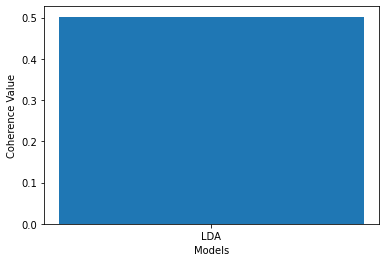

In [78]:
# evaluate_bar_graph([lda_coherence],
#                    ['LDA'])

In [ ]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [ ]:
# подсчёт когерентности моделей
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [ ]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])